# Implementing doND using the dataset

In [1]:
from functools import partial
import os

import numpy as np

from qcodes.dataset.sqlite.database import initialise_or_create_database_at
from qcodes.dataset.experiment_container import load_or_create_experiment
from qcodes.tests.instrument_mocks import DummyInstrument
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_dataset

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : /home/vsts/.qcodes/logs/command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


Qcodes Logfile : /home/vsts/.qcodes/logs/200218-17888-qcodes.log


In [2]:
tutorial_db_path = os.path.join(os.getcwd(), 'tutorial_doND.db')
initialise_or_create_database_at(tutorial_db_path)
load_or_create_experiment("doNd-tutorial", sample_name="no sample")

0it [00:00, ?it/s]

Upgrading database; v0 -> v1: : 0it [00:00, ?it/s]

Upgrading database; v0 -> v1: : 0it [00:00, ?it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v1 -> v2:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v1 -> v2: 100%|██████████| 1/1 [00:00<00:00, 739.08it/s]


0it [00:00, ?it/s]

Upgrading database; v2 -> v3: : 0it [00:00, ?it/s]

Upgrading database; v2 -> v3: : 0it [00:00, ?it/s]


0it [00:00, ?it/s]

Upgrading database; v3 -> v4: : 0it [00:00, ?it/s]

Upgrading database; v3 -> v4: : 0it [00:00, ?it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v4 -> v5:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v4 -> v5: 100%|██████████| 1/1 [00:00<00:00, 945.09it/s]


0it [00:00, ?it/s]

Upgrading database; v5 -> v6: : 0it [00:00, ?it/s]

Upgrading database; v5 -> v6: : 0it [00:00, ?it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v6 -> v7:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v6 -> v7: 100%|██████████| 1/1 [00:00<00:00, 297.24it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v7 -> v8:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v7 -> v8: 100%|██████████| 1/1 [00:00<00:00, 945.94it/s]

doNd-tutorial#no sample#1@/home/vsts/work/1/s/docs/examples/DataSet/tutorial_doND.db
------------------------------------------------------------------------------------

First we borrow the dummy instruments from the contextmanager notebook to have something to measure.

In [3]:
# preparatory mocking of physical setup
dac = DummyInstrument('dac', gates=['ch1', 'ch2'])
dmm = DummyInstrument('dmm', gates=['v1', 'v2'])

In [4]:
# and we'll make a 2D gaussian to sample from/measure
def gauss_model(x0: float, y0: float, sigma: float, noise: float=0.0005):
    """
    Returns a generator sampling a gaussian. The gaussian is
    normalised such that its maximal value is simply 1
    """
    while True:
        (x, y) = yield
        model = np.exp(-((x0-x)**2+(y0-y)**2)/2/sigma**2)*np.exp(2*sigma**2)
        noise = np.random.randn()*noise
        yield model + noise

In [5]:
# and finally wire up the dmm v1 to "measure" the gaussian

gauss = gauss_model(0.1, 0.2, 0.25)
next(gauss)

def measure_gauss(dac):
    val = gauss.send((dac.ch1.get(), dac.ch2.get()))
    next(gauss)
    return val

dmm.v1.get = partial(measure_gauss, dac)

Now lets reimplement the qdev-wrapper do1d function that can measure one one more parameters as a function of another parameter. This is more or less as simple as you would expect.


In [6]:
def do1d(param_set, start, stop, num_points, delay, *param_meas):
    meas = Measurement()
    meas.register_parameter(param_set)  # register the first independent parameter
    output = [] 
    param_set.post_delay = delay
    # do1D enforces a simple relationship between measured parameters
    # and set parameters. For anything more complicated this should be reimplemented from scratch
    for parameter in param_meas:
        meas.register_parameter(parameter, setpoints=(param_set,))
        output.append([parameter, None])

    with meas.run() as datasaver:
        for set_point in np.linspace(start, stop, num_points):
            param_set.set(set_point)
            for i, parameter in enumerate(param_meas):
                output[i][1] = parameter.get()
            datasaver.add_result((param_set, set_point),
                                 *output)
    dataset = datasaver.dataset  # convenient to have for plotting
    return dataset

In [7]:
dataset = do1d(dac.ch1, 0, 1, 10, 0.01, dmm.v1, dmm.v2)

Starting experimental run with id: 1. 


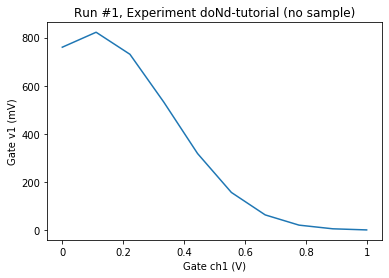

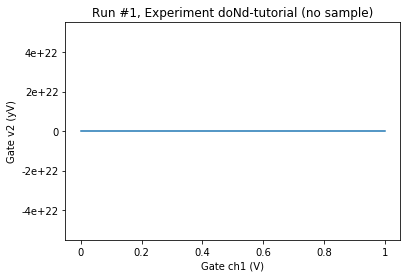

In [8]:
axes, cbaxes = plot_dataset(dataset)

In [9]:
def do2d(param_set1, start1, stop1, num_points1, delay1, 
         param_set2, start2, stop2, num_points2, delay2,
         *param_meas):
    # And then run an experiment

    meas = Measurement()
    meas.register_parameter(param_set1)
    param_set1.post_delay = delay1
    meas.register_parameter(param_set2)
    param_set1.post_delay = delay2
    output = [] 
    for parameter in param_meas:
        meas.register_parameter(parameter, setpoints=(param_set1,param_set2))
        output.append([parameter, None])

    with meas.run() as datasaver:
        for set_point1 in np.linspace(start1, stop1, num_points1):
            param_set1.set(set_point1)
            for set_point2 in np.linspace(start2, stop2, num_points2):
                param_set2.set(set_point2)
                for i, parameter in enumerate(param_meas):
                    output[i][1] = parameter.get()
                datasaver.add_result((param_set1, set_point1),
                                     (param_set2, set_point2),
                                     *output)
    dataset = datasaver.dataset  # convenient to have for plotting
    return dataset

In [10]:
dataset = do2d(dac.ch1, -1, 1, 100, 0.01, 
                     dac.ch2, -1, 1, 100, 0.01, 
                     dmm.v1, dmm.v2)

Starting experimental run with id: 2. 


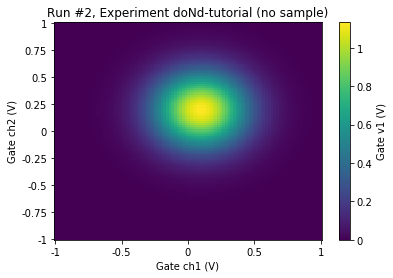

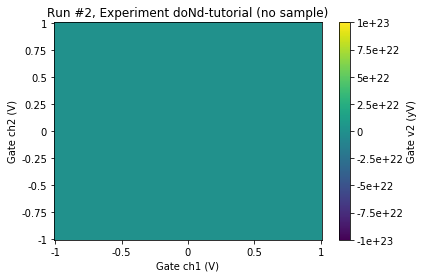

In [11]:
axes, cbaxes = plot_dataset(dataset)